In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from math import acos, sqrt
import warnings

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=(1.4))
%matplotlib inline

from IPython.core.display import HTML; css_file = '../2019/style.css'; HTML(open(css_file, "r").read())

# MS²PIP 2023 manuscript - Figures

This notebook contains the generation of the figures for the MS²PIP 2022 manuscript:


The notebook requires the following files:


The notebook was run in Python 3.8.13 with the following packages:

ipython==8.4.0\
numpy==1.23.0\
pandas==1.4.3\
matplotlib==3.5.2\
seaborn==0.11.2

## Functions

In [2]:
def ms2pip_pearson(true, pred):
    """
    Return pearson of tic-normalized, log-transformed intensities, 
    the MS2PIP way.
    """
    #tic_norm = lambda x: x / np.sum(x)
    # log_transform = lambda x: np.log2(x + 0.001)
    corr = pearsonr(
        true, 
        pred
    )[0]
    return (corr)


def spectral_angle(true, pred, epsilon=1e-7):
    """
    Return square root normalized spectral angle.
    See https://doi.org/10.1074/mcp.O113.036475
    """
    
    de_log = lambda x: (2**x)-0.001
    l2_normalize = lambda x: x / sqrt(max(sum(x**2), epsilon))
    
    pred_norm = l2_normalize(de_log(pred))
    true_norm = l2_normalize(de_log(true))
    
    spectral_angle = 1 - (2 * acos(np.dot(pred_norm, true_norm)) / np.pi)

    return (spectral_angle)

def data_loading(filename, filename_mapper):
    ms2pip_models = {
        "_HCD2019_": "2019 HCD",
        "_Immuno-HCD_": "Immuno HCD",
        "_CID_": "CID",
        "_CID-TMT": "CID-TMT",
        "_HCD2021_": "2021 HCD",
        "_TMT_": "TMT"
    }

    test_df = pd.read_csv("/home/arthur/ms2pip-nar-manuscript/" + filename)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df = test_df.groupby(["spec_id"]).agg({"prediction": list, "target": list}).reset_index()
        df["pearson"] = df.apply(lambda x: ms2pip_pearson(x.target, x.prediction), axis=1)
        df["SA"] = df.apply(lambda x: spectral_angle(np.array(x.target), np.array(x.prediction)), axis=1)
        df["data"] = filename_mapper[filename]
        for model_name, model in ms2pip_models.items():
            if model_name in filename:
                ms2pip_model = model
        df["model"] = ms2pip_model

        return df[["spec_id", "pearson", "SA", "data", "model"]]

def convert_liststring_to_list(liststring):
    liststring = liststring[1:-1]
    return [float(x) for x in liststring.split(",")]    


## Loading the prediction files

In [3]:
data_set_map = {
    "HCD_PXD008034_Ecoli_HCD2021_pred_and_emp.csv": "tryptic",
    "HCD_PXD008034_Ecoli_HCD2019_pred_and_emp.csv": "tryptic",
    "HCD_PXD008034_Ecoli_Immuno-HCD_pred_and_emp.csv": "tryptic",
    "spec_lib_PXD005231_HCD2019_pred_and_emp.csv": "HLA-I",
    "spec_lib_PXD005231_HCD2021_pred_and_emp.csv": "HLA-I",
    "spec_lib_PXD005231_Immuno-HCD_pred_and_emp.csv": "HLA-I",
    "spec_lib_pxd020011_Immuno-HCD_pred_and_emp.csv": "HLA-II",
    "spec_lib_pxd020011_HCD2019_pred_and_emp.csv": "HLA-II",
    "spec_lib_pxd020011_HCD2021_pred_and_emp.csv": "HLA-II",
    "test_spec_lib_PXD010154_HCD2021_pred_and_emp.csv": "chymotrypsin",
    "test_spec_lib_PXD010154_HCD2019_pred_and_emp.csv": "chymotrypsin",
    "test_spec_lib_PXD010154_Immuno-HCD_pred_and_emp.csv": "chymotrypsin"}

cid_tmt_map = {
        "spec_lib_pxd00589_CID-TMT_pred_and_emp.csv": "CID-TMT",
        "spec_lib_pxd00589_CID_pred_and_emp.csv": "CID-TMT",
        "spec_lib_pxd00589_TMT_pred_and_emp.csv": "CID-TMT",
        # "spec_lib_pxd00589_HCD2021_pred_and_emp.csv": "CID-TMT"
}

In [4]:
non_tryptic_correlations = pd.concat([data_loading(file, data_set_map) for file in data_set_map.keys()])
non_tryptic_correlations['data'] = pd.Categorical(non_tryptic_correlations['data'],
                                   categories=['tryptic', 'chymotrypsin', 'HLA-I', 'HLA-II'],
                                   ordered=True)
cid_tmt_correlations = pd.concat([data_loading(file, cid_tmt_map) for file in cid_tmt_map.keys()])

# Figure 1: Boxplots for novel tryptic models 

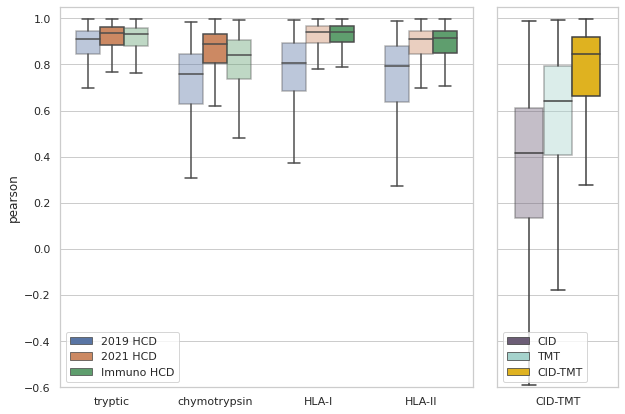

In [20]:
fig = plt.Figure(figsize=(10,7))
ax1 = plt.subplot2grid((1,4),(0,0), colspan=3, fig=fig)
sns.boxplot(
    data=non_tryptic_correlations,
    x="data",
    y="pearson",
    hue="model",
    showfliers= False,
    hue_order=["2019 HCD", "2021 HCD", "Immuno HCD"],
    ax=ax1,
    width=0.7,
    palette=sns.color_palette()

)
ax1.set_ylim(-0.6,1.1)
ax1.set_xlabel("")
ax1.get_legend().set_title("")
for i ,patch in enumerate(ax1.patches):
    if i not in [0,2,4 ,3,7, 11,14]:
        patch.set_alpha(0.4)

ax2 = plt.subplot2grid((1,4),(0,3), colspan=1, fig=fig, sharey=ax1)
sns.boxplot(
    data=cid_tmt_correlations,
    x="data",
    y="pearson",
    hue="model",
    showfliers= False,
    hue_order=[ "CID", "TMT", "CID-TMT"],
    ax=ax2,
    width=0.7,
    palette=sns.color_palette(["#6d597a","#9dd9d2" ,"#ffc300"])
)

for i ,patch in enumerate(ax2.patches):
    if i in [0,2,4, 1,3]:
        patch.set_alpha(0.4)

ax2.set_ylim(-0.6,1.05)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.tick_params(labelleft=False)
ax2.get_legend().set_title("")

fig.savefig("pearson_corr_plot.svg")
fig

In [7]:
non_tryptic_correlations.groupby(["data", "model"]).agg({"pearson": "median", "spec_id": "count"})

pearson  spec_id
data         model                        
tryptic      2019 HCD    0.910123    35212
             2021 HCD    0.934454    35212
             Immuno HCD  0.932352    35212
chymotrypsin 2019 HCD    0.756812    25798
             2021 HCD    0.886789    25570
             Immuno HCD  0.842392    25798
HLA-I        2019 HCD    0.805887    12534
             2021 HCD    0.939815    12534
             Immuno HCD  0.942002    12534
HLA-II       2019 HCD    0.791316    12745
             2021 HCD    0.911232    12745
             Immuno HCD  0.913439    12745

In [8]:
cid_tmt_correlations.groupby(["data", "model"]).agg({"pearson": "median", "spec_id": "count"})

pearson  spec_id
data    model                     
CID-TMT CID      0.417447    69768
        CID-TMT  0.844415    69768
        TMT      0.639954    69768

## Figure S1: chymotrypsin predictions based on length

In [9]:
peprec_pxd010154 = pd.read_table("/home/arthur/ms2pip-nar-manuscript/test_spec_lib_PXD010154.peprec", sep=" ")
chymotrypsin = non_tryptic_correlations[non_tryptic_correlations["data"] == "chymotrypsin"]
chymotrypsin["length"] = chymotrypsin["spec_id"].map(dict(zip(peprec_pxd010154["spec_id"], peprec_pxd010154["peptide"].apply(len))))

/tmp/ipykernel_3666314/370358189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chymotrypsin["length"] = chymotrypsin["spec_id"].map(dict(zip(peprec_pxd010154["spec_id"], peprec_pxd010154["peptide"].apply(len))))


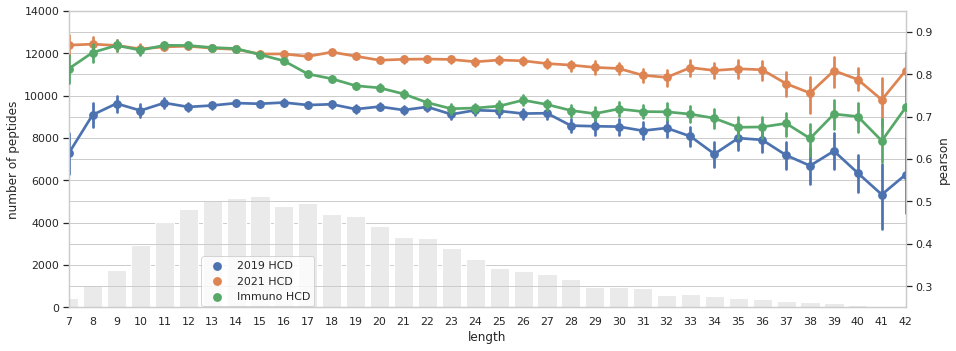

In [16]:
fig = plt.figure()
sns.set(style="whitegrid")

fig.add_subplot(211)

ax = sns.countplot(
x="length",
data=chymotrypsin,
color="#EAEAEA")
ax.axes.set_ylabel("number of peptides")
ax.axes.set_ylim([0,14000])
ax2=ax.twinx()
ax2 = sns.pointplot(
x="length",
y="pearson",
hue="model",
hue_order=["2019 HCD", "2021 HCD", "Immuno HCD"],
showfliers=False,
data=chymotrypsin,
legend= False)
ax2.axes.set_ylim([0.25,0.95])
ax2.set_xlim(0,35)
ax2.legend(bbox_to_anchor=(.30, 0.19), frameon=True)
fig.set_size_inches(15, 12)
plt.savefig("FigureS1.svg")
plt.show()

## Figure S2: intensity variance 

In [40]:
correlation_df = pd.read_table("/home/arthur/ms2pip-nar-manuscript/intensity_dataframe.txt", sep="\t")
for target in ["target_cid", "target_tmt", "target_cid_tmt"]:
    correlation_df[target] = correlation_df[target].apply(convert_liststring_to_list)


correlation_df["cid vs tmt"] = correlation_df.apply(lambda x: ms2pip_pearson(x.target_cid, x.target_tmt), axis=1)
correlation_df["cid vs cid-tmt"] = correlation_df.apply(lambda x: ms2pip_pearson(x.target_cid, x.target_cid_tmt), axis=1)
correlation_df["tmt vs cid-tmt"] = correlation_df.apply(lambda x: ms2pip_pearson(x.target_tmt, x.target_cid_tmt), axis=1)



cid vs tmt        0.231494
cid vs cid-tmt    0.439278
tmt vs cid-tmt    0.580408
dtype: float64

,peptide,charge,comparison,correlation
0,VSPVSYLR,2,cid vs tmt,-0.101978
1,LVMAAANR,2,cid vs tmt,-0.160815
2,LAASGEGGLQELSGHFENQK,3,cid vs tmt,0.695381
3,EHAIEEWK,3,cid vs tmt,0.609284
4,GVGDGTVSWGLEDDEDMTLTR,3,cid vs tmt,0.441028
...,...,...,...,...
10597,VPELYEIHK,3,tmt vs cid-tmt,0.905789
10598,DDAYWPEAK,2,tmt vs cid-tmt,0.696074
10599,VDDVYSVLR,2,tmt vs cid-tmt,0.190954
10600,LAQGHTTVDELAR,3,tmt vs cid-tmt,0.831351


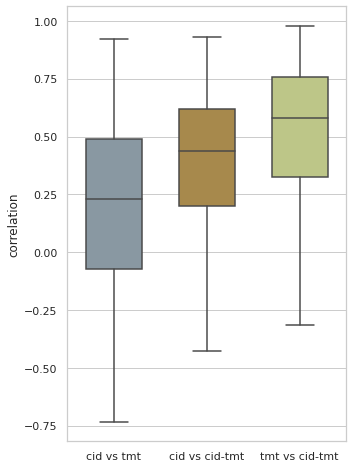

In [67]:
fig = plt.Figure(figsize=(5,8))
ax = fig.add_subplot(111)
sns.boxplot(
    data=correlation_df.melt(id_vars=["peptide", "charge"], value_vars=["cid vs tmt", "cid vs cid-tmt", "tmt vs cid-tmt"], var_name="comparison", value_name="correlation"),
    x="comparison",
    y="correlation",
    width=0.6,
    palette=sns.color_palette(["#8599a6", "#b68e3d", "#c4d07e"]),
    showfliers=False,
    ax=ax
)
ax.set_xlabel("")
fig

<AxesSubplot:>

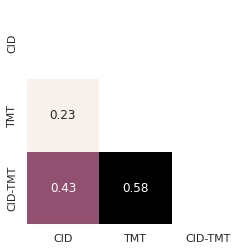

In [55]:
matrix = pd.DataFrame({"CID": [1, 0.23, 0.43],
    "TMT": [0.23, 1, 0.58],
    "CID-TMT": [0.43, 0.58, 1]}, index=["CID", "TMT", "CID-TMT"])
cmap = sns.cubehelix_palette(100, start=.3, rot=0.3, dark=0, light=.95, reverse=False)
sns.heatmap(
    matrix,
    square=True, 
    annot=True, 
    cmap=cmap, 
    cbar=False,
    mask=np.triu(matrix)
)